In [1]:
import os
import cv2
import time
import shutil
import random
import inspect
#import imageio as im
import numpy as np
import mahotas as mh
from PIL import Image
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import keras
from keras_unet.models import custom_unet

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

Could not import submodules (exact error was: numpy.core.multiarray failed to import).

There are many reasons for this error the most common one is that you have
either not built the packages or have built (using `python setup.py build`) or
installed them (using `python setup.py install`) and then proceeded to test
mahotas-imread **without changing the current directory**.

Try installing and then changing to another directory before importing mahotas.



RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

2023-04-08 17:50:26.944035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
experiment = "test3" 

In [3]:
# original directory path and working directory path for images
data = "/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/raw_files"
working_dir = "/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir"
######################################################################################################
#experiment = "test3" 
######################################################################################################
real = f"{working_dir}/{experiment}/real_images"
#########################################################################################################
machine = f"{working_dir}/{experiment}/pre_processing/machine"
npy = f"{working_dir}/{experiment}/pre_processing/npy"

directories = {
    "normalized": f"{working_dir}/{experiment}/normalized_images",
    "cropped": f"{working_dir}/{experiment}/cropped_images",
    "npy": f"{working_dir}/{experiment}/pre_processing/npy1",
    "originals": f"{working_dir}/{experiment}/pre_processing/originals",
    "masks": f"{working_dir}/{experiment}/pre_processing/masks",
    "test": f"{working_dir}/{experiment}/pre_processing/test",
    "s": f"{working_dir}/{experiment}/S",
    "crop_original": f"{working_dir}/{experiment}/pre_processing/crop_originals",
    "crop_masks": f"{working_dir}/{experiment}/pre_processing/crop_masks",
    "op": f"{working_dir}/{experiment}/post_processing/original_prediction",
    "pp": f"{working_dir}/{experiment}/post_processing/processed_prediction"
    
}


In [4]:
npy = f"{working_dir}/{experiment}/pre_processing/npy1"
new_unet = f"{working_dir}/{experiment}/unet_prediction_save"

In [6]:
import keras
from keras_unet.models import custom_unet

In [208]:
def dataset1():
    imagedata = np.load(os.path.join(npy, 'poo.npz'))
    labeldata = np.load(os.path.join(npy, 'pom.npz'))
    return imagedata,labeldata
    

In [209]:
def dataset2():
    imagedata = np.load(os.path.join(npy, 'original.npz'))
    labeldata = np.load(os.path.join(npy, 'mask.npz'))
    return imagedata,labeldata

In [7]:
# imagedata = np.load(os.path.join(npy, 'original.npz'))
# labeldata = np.load(os.path.join(npy, 'mask.npz'))

In [8]:
imagedata = np.load(os.path.join(npy, 'poo.npz'))
labeldata = np.load(os.path.join(npy, 'pom.npz'))

In [9]:
images_file = imagedata['data']
images_name = imagedata['names']

In [10]:
len (images_name)


38052

In [11]:
labels_file = labeldata['data']
labels_name = labeldata['names']

In [12]:
images = images_file
labels = labels_file

In [13]:
images.shape

(38052, 512, 512)

In [14]:
labels.shape

(38052, 512, 512)

In [15]:
 # full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)
#test = test.reshape(test.shape[0],test.shape[1],test.shape[2],1)

In [16]:
images.shape

(38052, 512, 512, 1)

In [17]:
labels.shape

(38052, 512, 512, 1)

In [18]:
p = np.random.permutation(len(images))

In [19]:
images = images[p]
labels = labels[p]

In [20]:
labels = labels.astype(np.float64)

In [21]:
# images = images.astype(np.float64)
# for i in range(images.shape[0]):
#     images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually


In [22]:
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets with a ratio of 85:15
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15)

# # Further split the training set into training and validation sets with a ratio of 82:18
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765)

In [23]:
X_train = images[0:1350]
y_train = labels[0:1350]
X_val = images[1351:1570]
y_val = labels[1351:1570]
X_test = images[1571:]
y_test = labels[1571:]

In [24]:
y_train.shape

(1350, 512, 512, 1)

In [25]:
X_train.shape

(1350, 512, 512, 1)

In [26]:
from keras import regularizers
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras_unet.utils import plot_segm_history, plot_imgs
import cv2
from PIL import Image
from skimage.filters import threshold_otsu
from keras.preprocessing.image import ImageDataGenerator

import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [28]:
model = custom_unet(
                    input_shape=(512, 512, 1),
                    use_batch_norm=False,
                    num_classes=1,
                    filters=32,
                    dropout=0.5,
                    output_activation='sigmoid')

In [29]:
opt = keras.optimizer_v1.Adam(lr=0.01)

In [30]:
model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [31]:
path = '/raid/mpsych/RISTERLAB/kiran/flyem/K_Experiments/models/Unet'

In [32]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Training with early stopping
history = model.fit(X_train,
                    y_train,
                    batch_size=5,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


y_pred = model.predict(X_test)

for i in range(15):
    # Apply thresholding
    threshold = 0.2
    y_pred_binary = (y_pred [i]> threshold).astype(np.uint8)
    binary_mask = y_pred_binary
    z = images_name[i]
    plt.imshow(binary_mask)
    plt.show()

# save the updated weights of the new model
model.save_weights(f'{path}/new_Uidmodel1.h5')
print (f'saved model : new_Umodel1.h5')
threshold = 0.2
y_pred_binary = (y_pred > threshold).astype(np.uint8)
plot_segm_history(history)   
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)
    # Convert the binary_mask variable to a 2D array
  #  binary_mask_2d = binary_mask.squeeze()
    # Convert the binary_mask variable to uint8 format
#    binary_mask_uint8 = (binary_mask_2d * 255).astype(np.uint8)
   # save_path = os.path.join(new_unet, z) 
   # binary_mask_new = np.array(binary_mask_uint8)
    #mh.imsave(save_path, binary_mask_new)
    
 # Plotting results
# Apply thresholding


# history.history.keys()
# metrics = list(history.history.keys())
# plot_segm_history(history, metrics=metrics)   
# plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=30)

# #print ('completed iteration number',k,'The value of al is ',al)
print ('#############################')
print()
print()
print()

2023-04-08 17:52:06.026117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-08 17:52:06.045177: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-04-08 17:52:07.265953: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-08 17:52:07.888298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-08 17:52:08.543891: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-08 17:52:08.543919: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-08 17:52:08.543984: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-08 17:52:08.589227: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-08 17:52:09.297001: I tensorflow/stream_exec

135/135 [==============================] - 23s 113ms/step - loss: nan - iou: nan - iou_thresholded: 3.7931 - val_loss: nan - val_iou: nan - val_iou_thresholded: 1.4194e-08
Epoch 2/100
135/135 [==============================] - 13s 97ms/step - loss: nan - iou: nan - iou_thresholded: 1.3744e-08 - val_loss: nan - val_iou: nan - val_iou_thresholded: 1.4194e-08
Epoch 3/100
135/135 [==============================] - 13s 97ms/step - loss: nan - iou: nan - iou_thresholded: 1.3738e-08 - val_loss: nan - val_iou: nan - val_iou_thresholded: 1.4194e-08
Epoch 4/100
135/135 [==============================] - 13s 98ms/step - loss: nan - iou: nan - iou_thresholded: 1.3762e-08 - val_loss: nan - val_iou: nan - val_iou_thresholded: 1.4194e-08
Epoch 5/100
135/135 [==============================] - 13s 97ms/step - loss: nan - iou: nan - iou_thresholded: 1.3767e-08 - val_loss: nan - val_iou: nan - val_iou_thresholded: 1.4194e-08
Epoch 6/100
135/135 [==============================] - 13s 96ms/step - loss: nan

2023-04-08 17:57:01.287018: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB (rounded to 2147483648)requested by op model_1/concatenate_7/concat
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-08 17:57:01.287855: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-04-08 17:57:01.287928: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 90, Chunks in use: 89. 22.5KiB allocated for chunks. 22.2KiB in use in bin. 6.3KiB client-requested in use in bin.
2023-04-08 17:57:01.288004: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 17, Chunks in use: 15. 8.8KiB allocated for chunks. 7.5KiB in use in bin. 7.5KiB client-requested in use in bin.
2023-04-08 17:5

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/concatenate_7/concat (defined at tmp/ipykernel_1008204/4042140265.py:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_9120]

Function call stack:
predict_function


Epoch 1/100
22/22 [==============================] - 17s 724ms/step - loss: 4.2619 - iou: 0.0594 - iou_thresholded: 0.0585 - val_loss: 0.6628 - val_iou: 0.0910 - val_iou_thresholded: 0.0877
Epoch 2/100
22/22 [==============================] - 16s 706ms/step - loss: 0.6613 - iou: 0.0777 - iou_thresholded: 0.0484 - val_loss: 0.4254 - val_iou: 0.0826 - val_iou_thresholded: 0.0013
Epoch 3/100
22/22 [==============================] - 15s 699ms/step - loss: 0.4408 - iou: 0.0825 - iou_thresholded: 0.0171 - val_loss: 0.4356 - val_iou: 0.1020 - val_iou_thresholded: 1.0536e-04
Epoch 4/100
22/22 [==============================] - 15s 697ms/step - loss: 0.3959 - iou: 0.0863 - iou_thresholded: 0.0044 - val_loss: 0.4614 - val_iou: 0.1073 - val_iou_thresholded: 4.9538e-05
Epoch 5/100
22/22 [==============================] - 16s 709ms/step - loss: 0.3664 - iou: 0.0971 - iou_thresholded: 0.0020 - val_loss: 0.4123 - val_iou: 0.1145 - val_iou_thresholded: 4.9130e-05
Epoch 6/100
22/22 [===================

Epoch 86/100
22/22 [==============================] - 16s 708ms/step - loss: 0.0716 - iou: 0.6034 - iou_thresholded: 0.8211 - val_loss: 0.0799 - val_iou: 0.5709 - val_iou_thresholded: 0.8078
Epoch 87/100
22/22 [==============================] - 16s 707ms/step - loss: 0.0689 - iou: 0.6122 - iou_thresholded: 0.8308 - val_loss: 0.0773 - val_iou: 0.5835 - val_iou_thresholded: 0.8103
Epoch 88/100
22/22 [==============================] - 16s 706ms/step - loss: 0.0679 - iou: 0.6137 - iou_thresholded: 0.8308 - val_loss: 0.0737 - val_iou: 0.5869 - val_iou_thresholded: 0.8288
Epoch 89/100
22/22 [==============================] - 16s 709ms/step - loss: 0.0686 - iou: 0.6136 - iou_thresholded: 0.8271 - val_loss: 0.0850 - val_iou: 0.5588 - val_iou_thresholded: 0.7908
Epoch 90/100
22/22 [==============================] - 15s 703ms/step - loss: 0.0720 - iou: 0.6048 - iou_thresholded: 0.8132 - val_loss: 0.0740 - val_iou: 0.6013 - val_iou_thresholded: 0.8171
Epoch 91/100
22/22 [=========================

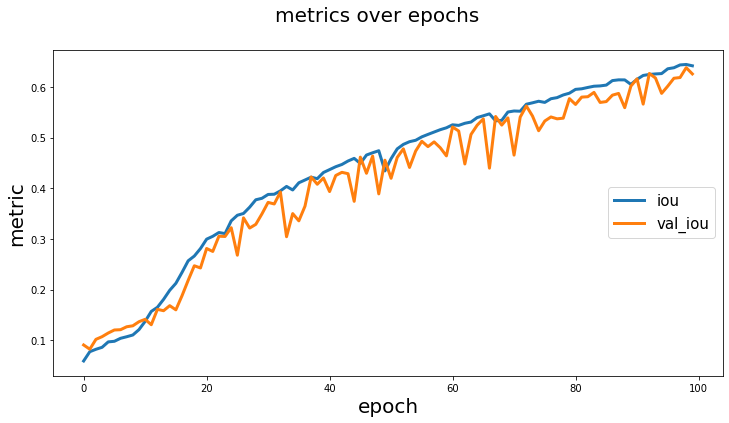

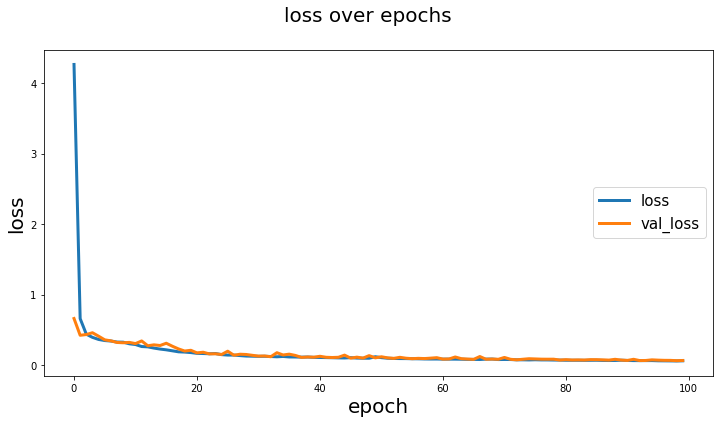

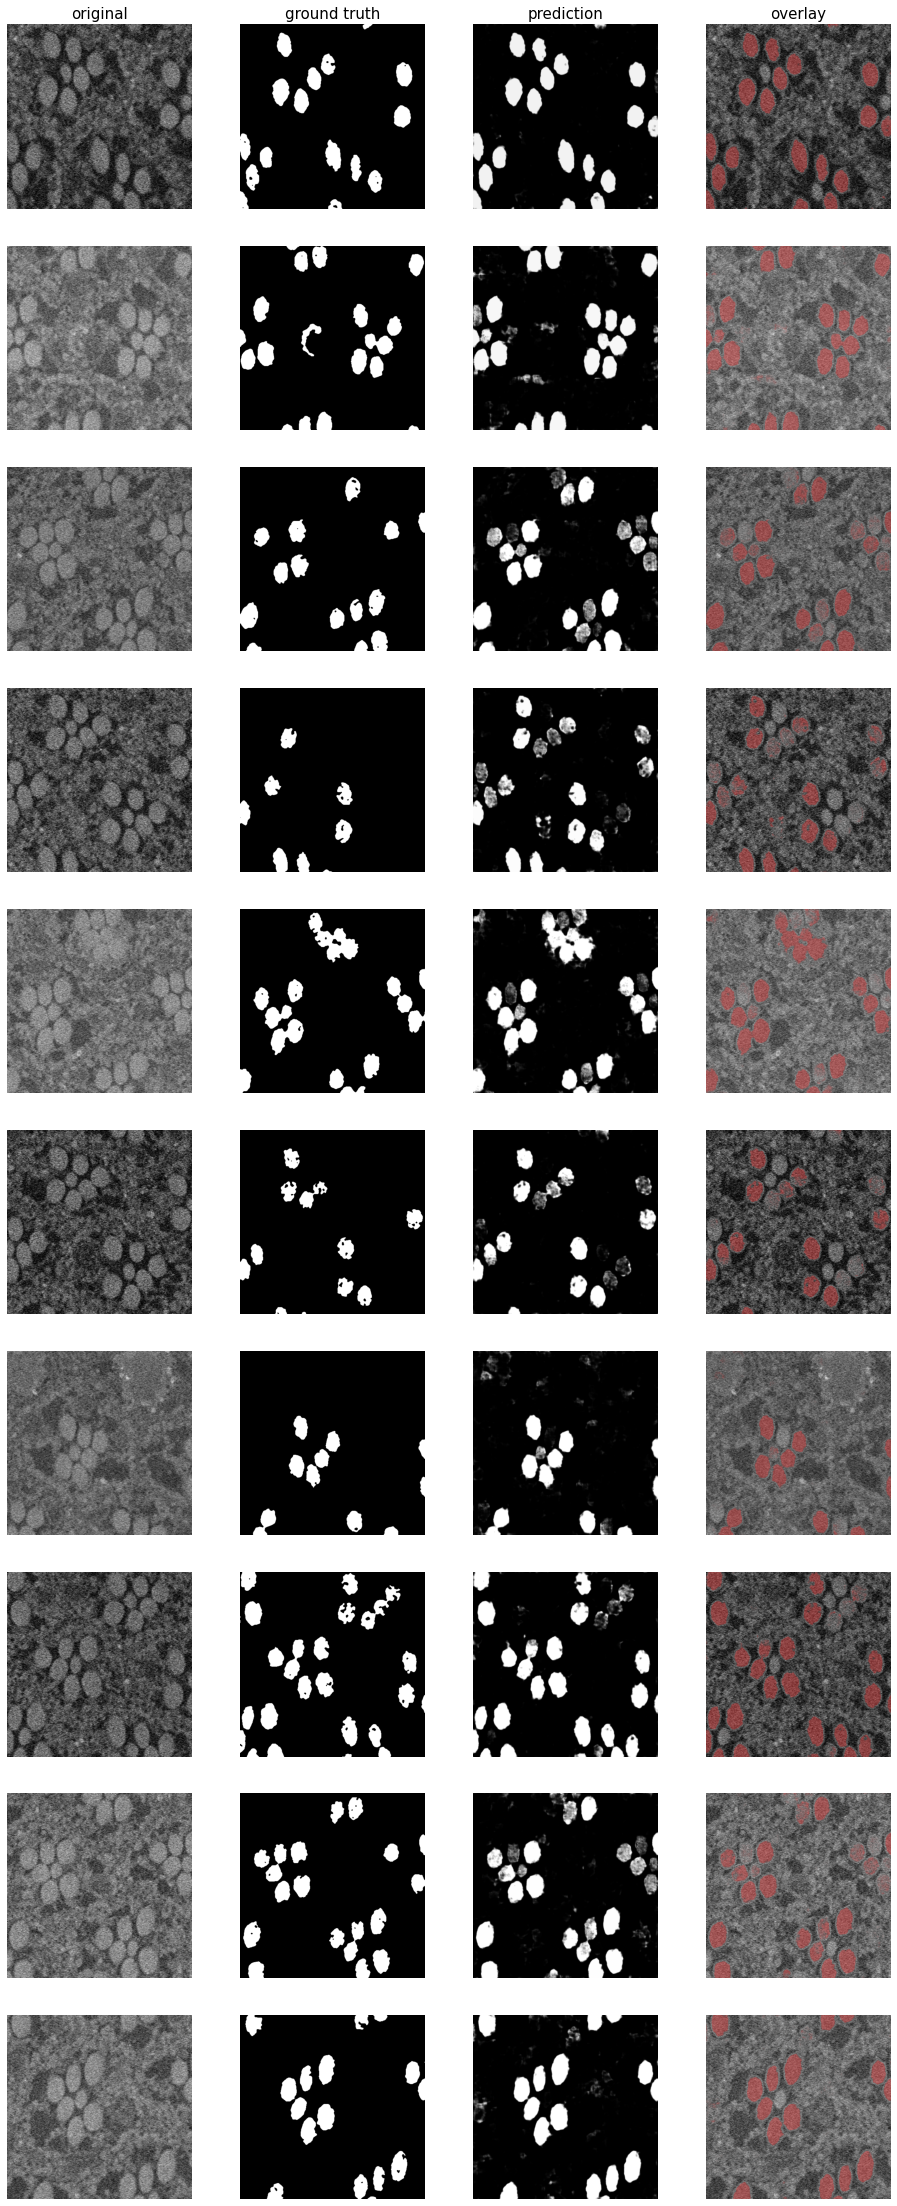

#############################





In [252]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Training with early stopping
history = model.fit(X_train,
                    y_train,
                    batch_size=60,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


y_pred = model.predict(X_test)

for i in range(15):
    # Apply thresholding
    threshold = 0.2
    y_pred_binary = (y_pred > threshold).astype(np.uint8)
    binary_mask = y_pred_binary[i]
    z = images_name[i]
    # Convert the binary_mask variable to a 2D array
    binary_mask_2d = binary_mask.squeeze()
    # Convert the binary_mask variable to uint8 format
    binary_mask_uint8 = (binary_mask_2d * 255).astype(np.uint8)
    save_path = os.path.join(new_unet, z) 
    binary_mask_new = np.array(binary_mask_uint8)
    mh.imsave(save_path, binary_mask_new)
    
# save the updated weights of the new model
new_model.save_weights(f'{path}/new_Umodel{bl}.h5')
print (f'saved model : new_Umodel{bl}.h5')
threshold = 0.2
y_pred_binary = (y_pred > threshold).astype(np.uint8)
plot_segm_history(history)   
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

# history.history.keys()
# metrics = list(history.history.keys())
# plot_segm_history(history, metrics=metrics)   
# plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=30)

# #print ('completed iteration number',k,'The value of al is ',al)
print ('#############################')
print()
print()
print()

In [ ]:
def create_Umodel():
    import keras.optimizers
    from keras_unet.metrics import iou, iou_thresholded
    from keras_unet.losses import jaccard_distance
    model = custom_unet(
                    input_shape=(512, 512, 1),
                    use_batch_norm=False,
                    num_classes=1,
                    filters=32,
                    dropout=0.5,
                    output_activation='sigmoid')


In [ ]:
def wtrain(number):
    from keras import regularizers
    from keras.layers import Dense
    from keras.callbacks import EarlyStopping
    from keras.preprocessing.image import ImageDataGenerator
    from keras_unet.utils import plot_segm_history, plot_imgs
    import cv2
    from PIL import Image
    from skimage.filters import threshold_otsu
    from keras.preprocessing.image import ImageDataGenerator
    al = 1
    for k in range(number):
        # create a new model with the same architecture as the original model
        new_model = create_Umodel()
        path = '/raid/mpsych/RISTERLAB/kiran/flyem/K_Experiments/models/Unet'
        # load the previously saved weights into the new model
        new_model.load_weights(f'{path}/new_Umodel{al}.h5')
        print (f'loaded model : new_Umodel{al}.h5')
        # compile the new model        
        opt = keras.optimizer_v1.Adam(lr=0.01)
        # compile the new model
        new_model.compile(optimizer = 'Adam',    
                          loss='binary_crossentropy', 
                          metrics=[iou, iou_thresholded])
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        # Training with early stopping
        history = model.fit(X_train,
                            y_train,
                            batch_size=60,
                            epochs=700,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])


        bl = (al+1)
        # save the updated weights of the new model
        new_model.save_weights(f'{path}/new_Umodel{bl}.h5')
        
        print (f'saved model : new_Umodel{bl}.h5')
        # Make predictions and apply thresholding
        y_pred = new_model.predict(X_test)



#         for i in range(5):
#             binary_mask = y_pred[i]
#             z = images_name[i]
#             threshold = 0.2
#             binary_mask = (binary_mask[i] > threshold).astype(np.uint8)
#             # Convert the binary_mask variable to a 2D array
#             binary_mask_2d = binary_mask.squeeze()
#             Convert the binary_mask variable to uint8 format
#             binary_mask_uint8 = (binary_mask_2d * 255).astype(np.uint8)
#             save_path = os.path.join(dir_path, z) 
#             binary_mask_new = np.array(binary_mask_uint8)
#             mh.imsave(save_path, binary_mask_new)
            
        threshold = 0.2
        y_pred_binary = (y_pred[i] > threshold).astype(np.uint8)
        plot_segm_history(history)   
        plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10
        al += 1
        print ('completed iteration number',k,'The value of al is ',al)
        print ('#############################')
        print()
        print()
        print()

In [ ]:
wtrain(5)